# Tema 21: Medidas de asociación y correlación

En esta libreta analizaremos diferentes medidas de asociación para diferentes conjuntos de datos, tanto numéricos como categóricos.

We'll consider the following flowchart
```{mermaid}
flowchart TD
    A[Dos variables] --> B{¿Tipo?}

    B --> C[Ambas categóricas]
    C --> D{¿Frecuencias esperadas ≥ 5?}
    D -- Sí --> F[χ² de Pearson]
    D -- No --> G[Test exacto de Fisher]

    F --> Cef[Medida de efecto]
    G --> Cef

    Cef --> OR[Odds Ratio]
    Cef --> V[V de Cramer]
    Cef --> Phi[Coeficiente Phi]

    B --> H[Una y Una]
    H --> I[Correlación Rango-Biserial]

    B --> J[Ambas numéricas]
    J --> K{¿Supuestos paramétricos?}
    K -- No --> L[Rho de Spearman]
    K -- No --> M[Tau de Kendall]
    K -- Sí --> N[r de Pearson]

```

Pese a que este tipo de diagramas son muy limitados, lo uso aquí solo con fines de resumen, no de guía. Siempre decide la prueba adecuada con base en tu contexto científico.

## Librerías y datos
Utilizaremos datos de un dataset público que puedes encontrar [aquí](https://www.kaggle.com/datasets/pritsheta/heart-attack/data).
La fichas técnica del dataset contiene la siguiente información:

 1. Age: Age (in years) 
 2. Sex: gender (1 = male; 0 = female) 
 3. ChestPain: Chest Pain type .
    - typical angina (all criteria present) 
    - atypical angina (two of three criteria satisfied)
    - non-anginal pain (less than one criteria satisfied)
    - asymptomatic (none of the criteria are satisfied) 
4. Restbps: Resting Blood pressure (in mmHg, upon admission to the hospital) 
5. Chol: serum cholesterol in mg/dL 
6. Fbs: fasting blood sugar > 120 mg/dL (likely to be diabetic) 1 = true; 0 = false 
7. RestECG: Resting electrocardiogram results 
    - Value 0: normal 
    - Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV) 
    - Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria 
8. MaxHR: Greatest number of beats per minute your heart can possibly reach during all-out strenuous exercise. 
9. Exang: exercise induced angina (1 = yes; 0 = no) 
10. Oldpeak: ST depression induced by exercise relative to rest (in mm, achieved by subtracting the lowest ST segment points during exercise and rest) 
11. Slope: the slope of the peak exercise ST segment, ST-T abnormalities are considered to be a crucial indicator for identifying presence of ischaemia 
    - Value 1: upsloping 
    - Value 2: flat 
    - Value 3: downsloping 
12. Ca: number of major vessels (0-3) colored by fluoroscopy. Major cardial vessels are as goes: aorta, superior vena cava, inferior vena cava, pulmonary artery (oxygen-poor blood --> lungs), pulmonary veins (oxygen-rich blood --> heart), and coronary arteries (supplies blood to heart tissue). 
13. AHD: 0 = normal; 1 = fixed defect (heart tissue can't absorb thallium both under stress and in rest); 2 = reversible defect (heart tissue is unable to absorb thallium only under the exercise portion of the test) 
14. AHD: 0 = no disease, 1 = disease


In [43]:
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

url = 'https://raw.githubusercontent.com/chrisdewa/curso_python/refs/heads/main/bases/Heart_Attack_Data.csv'
df = pd.read_csv(url)
df.head()


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


Ahora que tenemos los datos, pasemos al análisis.

## Dos variables categóricas

Utilizaremos las variables `sex` y `target`.
Primero obtengamos la tabla cruzada como se hizo en la lección previa.

In [4]:
tab = pd.crosstab(df['sex'], df['target'])
tab

target,0,1
sex,,
0,24,72
1,114,93


In [5]:
tab.shape

(2, 2)

Crearemos una función que realizará la chi cuadrada, obendrá el OR y su intervalo de confianza e imprimirá en la consola el resultado, además, verificará el supuesto de las frecuencias esperadas.

In [23]:
def chi_cuadrada(tab):
    """Calcula la chi2 y general un reporte de la tabla 2x2"""
    # verificar tipo de tabla
    if tab.shape != (2,2):
        raise ValueError('La tabla debe ser 2x2')
    chi = stats.chi2_contingency(tab)
    OR = stats.contingency.odds_ratio(tab, kind='sample')
    low, high = OR.confidence_interval()
    cumple_frec = bool(v>5 for v in chi.expected_freq.flatten())
    print(f'Resutado de Chi cuadrada: p={chi.pvalue:.1e}, OR={OR.statistic:.2f} (IC 95% {low:.2f} - {high:.2f})')

    

In [24]:
chi_cuadrada(tab)

Resutado de Chi cuadrada: p=1.9e-06, OR=0.27 (IC 95% 0.16 - 0.47)


Podemos ver que existe una asociación significativa entre la presencia de la enfermedad y el sexo. Como en la tabla está codificado el sexo masculino como 1, curiosamente en estos datos, ser hombre es protector para la enfermedad cardiaca aguda. Además, podemos ver que la p es muy significativa, al igual que el odds ratio. 

### Ejercio
1. Revisa la documentación de las funciones `chi2_contingecy` y `odds_ratio`. 
2. Ajusta la función para que acepte argumentos adicionales, de forma que podamos calcular intervalos de confianza para diferentes niveles de alfa.
3. Ajusta la función para el parámetro "kind" de la función `odds_ratio`, pero primero asegúrate de entender qué hace.
4. Implementa una función diferente que funcione con la exacta de fisher.

### Otros tamaños del efecto
Veremos cómo calcular la V de Cramer y el coeficiente phi.

In [26]:
v = stats.contingency.association(tab, method='cramer')
phi = stats.pearsonr(df['sex'], df['target'])
print(f'V de Cramer: {v}, Phi: {phi.statistic}')

V de Cramer: 0.280936575501767, Phi: -0.28093657550176704


### Matriz de asociación
Ahora, podemos utilizar estas métricas, ya que no son exclusivas para datos 2x2, para generar matrices de asociación. Revisando los datos, las variables categóricas son: sex, cp, fbs, restecg, exang, splope, thal, target.

Primero crearemos una función que tome A y B, como series de un `dataframe` y  genere una tabulación cruzada y calcule la V de Cramer.

In [29]:
def cramer_v(a, b):
    tab = pd.crosstab(a, b)
    v = stats.contingency.association(tab)
    return v

cramer_v(df['sex'], df['target'])

0.280936575501767

Ahora utilizaremos la función para generar la matriz de asociación.

In [41]:
categoricas = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal', 'target']
# utilizaremos la lista para filtrar el dataset y solo seccionar esas columnas.
matriz_asoc = df[categoricas].corr(cramer_v)
matriz_asoc

,sex,cp,fbs,restecg,exang,slope,thal,target
sex,1.000000,0.150050,0.045032,0.110464,0.141664,0.046257,0.383770,0.280937
cp,0.150050,1.000000,0.113242,0.126437,0.471457,0.213981,0.214676,0.519223
fbs,0.045032,0.113242,1.000000,0.087068,0.025665,0.105514,0.135242,0.028046
restecg,0.110464,0.126437,0.087068,1.000000,0.099106,0.134401,0.076283,0.181878
exang,0.141664,0.471457,0.025665,0.099106,1.000000,0.287995,0.329812,0.436757
slope,0.046257,0.213981,0.105514,0.134401,0.287995,1.000000,0.241295,0.395965
thal,0.383770,0.214676,0.135242,0.076283,0.329812,0.241295,1.000000,0.530594
target,0.280937,0.519223,0.028046,0.181878,0.436757,0.395965,0.530594,1.000000


Podemos ahora generar un mapa de calor

Text(0.5, 1.0, 'Asociación de categóricas: V de Cramer')

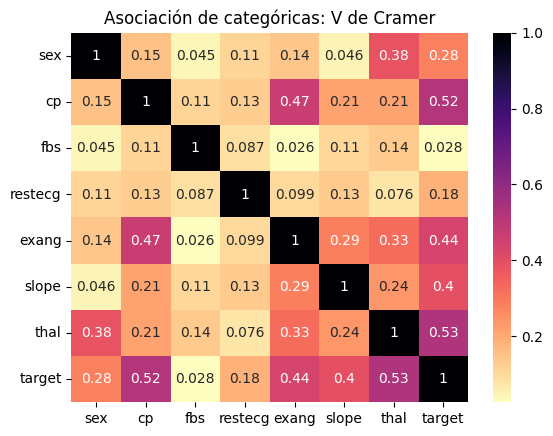

In [44]:
sns.heatmap(
    matriz_asoc.round(3), # para mostrar solo 3 decimales
    annot=True,
    cmap='magma_r'
)
plt.title('Asociación de categóricas: V de Cramer')

## Una categórica y una numérica

Para analizar la asociación podemos utilizar la correlación punto biserial, que está implementada directamente en scipy.
Utilicemos `target` y `age`.

In [45]:
stats.pointbiserialr(df['target'], df['age']) # x debe ser cat, y num


SignificanceResult(statistic=np.float64(-0.22543871587483735), pvalue=np.float64(7.524801303442137e-05))

## Dos numéricas
Ahora veamos cómo ejecutar las diferentes correlaciones.

### Pearson

In [47]:
stats.pearsonr(df['trestbps'], df['chol'])

PearsonRResult(statistic=np.float64(0.12317420653239072), pvalue=np.float64(0.03208205361087139))

### Spearman

In [48]:
stats.spearmanr(df['trestbps'], df['chol'])

SignificanceResult(statistic=np.float64(0.12656163345944624), pvalue=np.float64(0.027608539162108585))

### Kendall Tau
#### Variante B

In [51]:
stats.kendalltau(df['trestbps'], df['chol'], variant='b')

SignificanceResult(statistic=np.float64(0.08647408139339434), pvalue=np.float64(0.029128580856773133))

#### Variante C

In [52]:
stats.kendalltau(df['trestbps'], df['chol'], variant='c')

SignificanceResult(statistic=np.float64(0.08526124889716695), pvalue=np.float64(0.029128580856773133))

## Ejercicios
1. Grafica las correlaciones.
2. Continúa explorando los datos presentados.
3. Revisa la página del dataset: https://www.kaggle.com/datasets/pritsheta/heart-attack/data.
4. Revisa el código de otros para ver qué tipos de análisis utilizan.
5. Revisa estas dos libretas en particular: 
    - https://www.kaggle.com/code/zohaib123/heart-disease-prediction-research-work
    - https://www.kaggle.com/code/asifpervezpolok/heart-attack-prediction-eda
    
